In [1]:
import random
import torch
from torch import nn
from torch import optim
import numpy as np

In [2]:
import sys
sys.path.append('/kaggle/input/nma-util/util')

In [3]:
def set_seed(seed=None, seed_torch=True):
    """
    Function that controls randomness. NumPy and random modules must be imported.

    Args:
      seed : Integer
        A non-negative integer that defines the random state. Default is `None`.
      seed_torch : Boolean
        If `True` sets the random seed for pytorch tensors, so pytorch module
        must be imported. Default is `True`.

    Returns:
      Nothing.
    """
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')

In [4]:
set_seed(1)

Random seed 1 has been set.


## Step 1: Setup You Tokenizer 


In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

## Step 2: Get DataLoaders

In [6]:
from data_pipeline import get_data_loaders

english_train_loader, english_validation_loader, target_validation_loader, target_test_loader = get_data_loaders(tokenizer, presentage=0.5,
                                                                                                                 batch_size=1024, max_length=128)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/99.1M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/393435 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/393436 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Filter:   0%|          | 0/393435 [00:00<?, ? examples/s]

Filter:   0%|          | 0/393436 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Filter:   0%|          | 0/393435 [00:00<?, ? examples/s]

Filter:   0%|          | 0/393436 [00:00<?, ? examples/s]

## Step 3: Load The Model

In [7]:
from transformers import BertModel

# Load pretrained multilingual BERT model
model = BertModel.from_pretrained("bert-base-multilingual-uncased")

# -------------------------------
# Freeze embedding layer
# -------------------------------
for param in model.embeddings.parameters():
    param.requires_grad = False

# -------------------------------
# Keep only the first 6 encoder layers
# -------------------------------
model.encoder.layer = model.encoder.layer[:6]

# -------------------------------
# Freeze the first 4 of those layers
# -------------------------------
for layer in model.encoder.layer[:4]:
    for param in layer.parameters():
        param.requires_grad = False

2025-07-21 11:45:51.242449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753098351.507359      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753098351.583249      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

## Step 4: Setup The Model

In [8]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertSentimentClassifier, self).__init__()
        self.bert = bert_model
        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        # Add a fully connected layer for classification
        # The output dimension of BERT's [CLS] token is usually the hidden size
        # which is 768 for bert-base-multilingual-uncased
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # Get the output from the BERT model
        # We only need the [CLS] token representation for classification
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        # Get the hidden states of the [CLS] token (first token)
        cls_representation = outputs.last_hidden_state[:, 0, :]
        # Apply dropout
        cls_representation = self.dropout(cls_representation)
        # Pass the [CLS] representation through the classifier
        logits = self.classifier(cls_representation)
        return logits

# Instantiate the classifier
# Assuming the dataset has 3 classes: positive, neutral, negative
num_classes = 3
sentiment_classifier = BertSentimentClassifier(model, num_classes)

sentiment_classifier

BertSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Step 4: Setup Training Hyperparameters & Optimizer

In [9]:
# Training hyperparameters
learning_rate = 5e-5  # Common learning rate for fine-tuning BERT
num_epochs = 10        # Typical for BERT fine-tuning

# Setup optimizer
# Use AdamW optimizer which is recommended for transformers
optimizer = optim.AdamW(
    sentiment_classifier.parameters(),
    lr=learning_rate
)

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=5e-6)  # eta_min is optional

In [11]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_classifier.to(device)

BertSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Step 6: Setup The Trainer

In [12]:
from model_trainer import ModelTrainer

trainer = ModelTrainer(sentiment_classifier, optimizer, device, num_epochs, english_train_loader, english_validation_loader,
                       target_validation_loader, target_test_loader, scheduler)

In [13]:
history = trainer.train()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.6185, Acc: 0.7251 | LR: 4.89e-05
  English Val - Loss: 0.5364, Acc: 0.7668
  Target Val  - Loss: 0.8218, Acc: 0.7078


Training Epoch 2:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.5258, Acc: 0.7719 | LR: 4.57e-05
  English Val - Loss: 0.5068, Acc: 0.7814
  Target Val  - Loss: 0.8463, Acc: 0.7185


Training Epoch 3:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.4956, Acc: 0.7857 | LR: 4.07e-05
  English Val - Loss: 0.4868, Acc: 0.7911
  Target Val  - Loss: 0.8550, Acc: 0.7074


Training Epoch 4:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.4768, Acc: 0.7947 | LR: 3.45e-05
  English Val - Loss: 0.4877, Acc: 0.7908
  Target Val  - Loss: 0.8976, Acc: 0.7114


Training Epoch 5:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.4617, Acc: 0.8018 | LR: 2.75e-05
  English Val - Loss: 0.4763, Acc: 0.7972
  Target Val  - Loss: 0.8731, Acc: 0.7047


Training Epoch 6:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.4496, Acc: 0.8068 | LR: 2.05e-05
  English Val - Loss: 0.4735, Acc: 0.7985
  Target Val  - Loss: 0.9165, Acc: 0.7083


Training Epoch 7:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.4399, Acc: 0.8117 | LR: 1.43e-05
  English Val - Loss: 0.4734, Acc: 0.7992
  Target Val  - Loss: 0.8880, Acc: 0.7145


Training Epoch 8:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.4314, Acc: 0.8149 | LR: 9.30e-06
  English Val - Loss: 0.4739, Acc: 0.7999
  Target Val  - Loss: 0.9198, Acc: 0.7143


Training Epoch 9:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.4259, Acc: 0.8178 | LR: 6.10e-06
  English Val - Loss: 0.4709, Acc: 0.8009
  Target Val  - Loss: 0.9734, Acc: 0.7023


Training Epoch 10:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.4216, Acc: 0.8193 | LR: 5.00e-06
  English Val - Loss: 0.4732, Acc: 0.8002
  Target Val  - Loss: 1.0087, Acc: 0.7038
Training history saved to checkpoints/training_history.json


## Step 7: Plotting & Saving Graphs

In [14]:
from visualizer import TrainingVisualizer

training_visualizer = TrainingVisualizer()

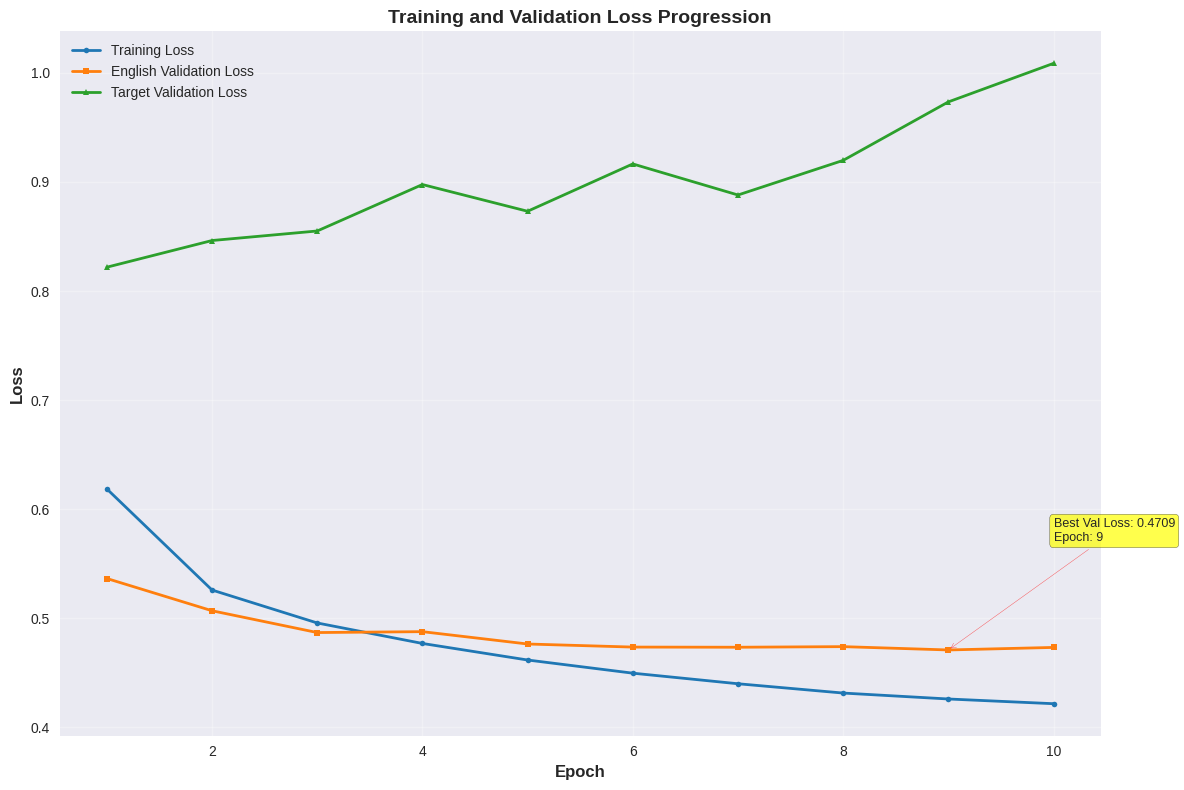

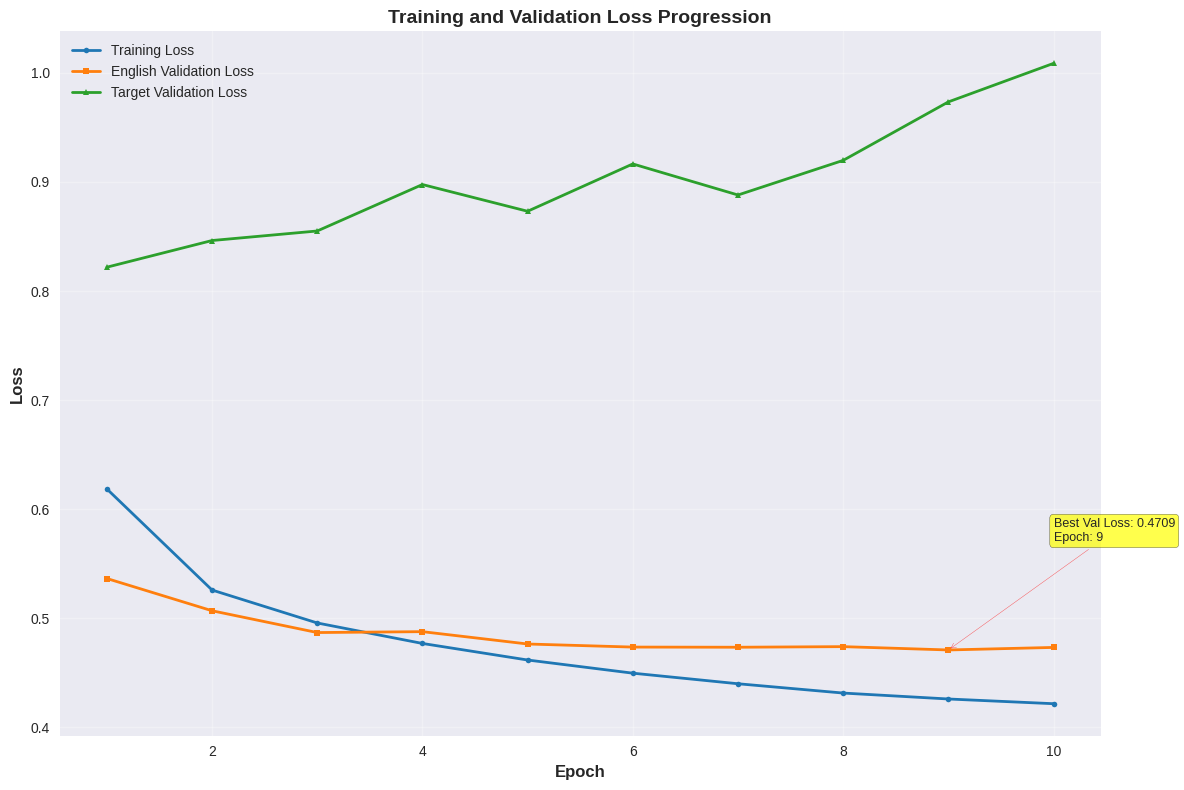

In [15]:
training_visualizer.plot_losses(history)

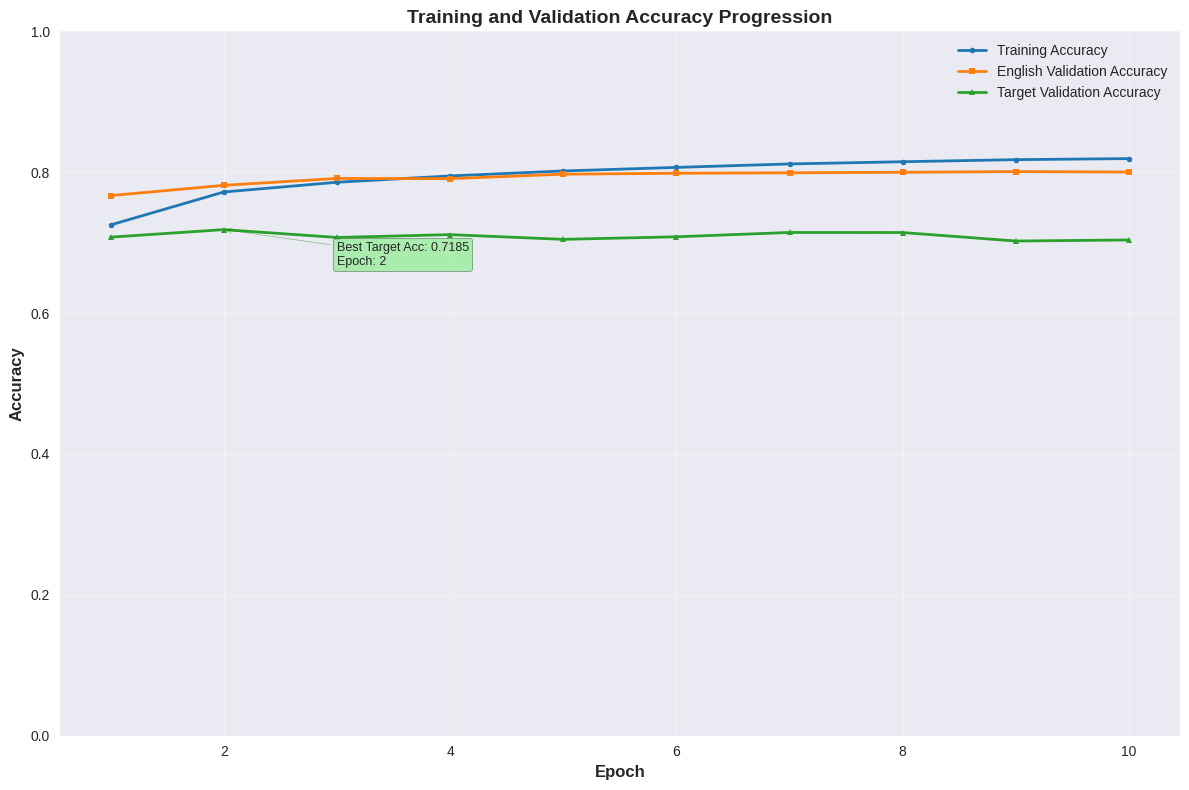

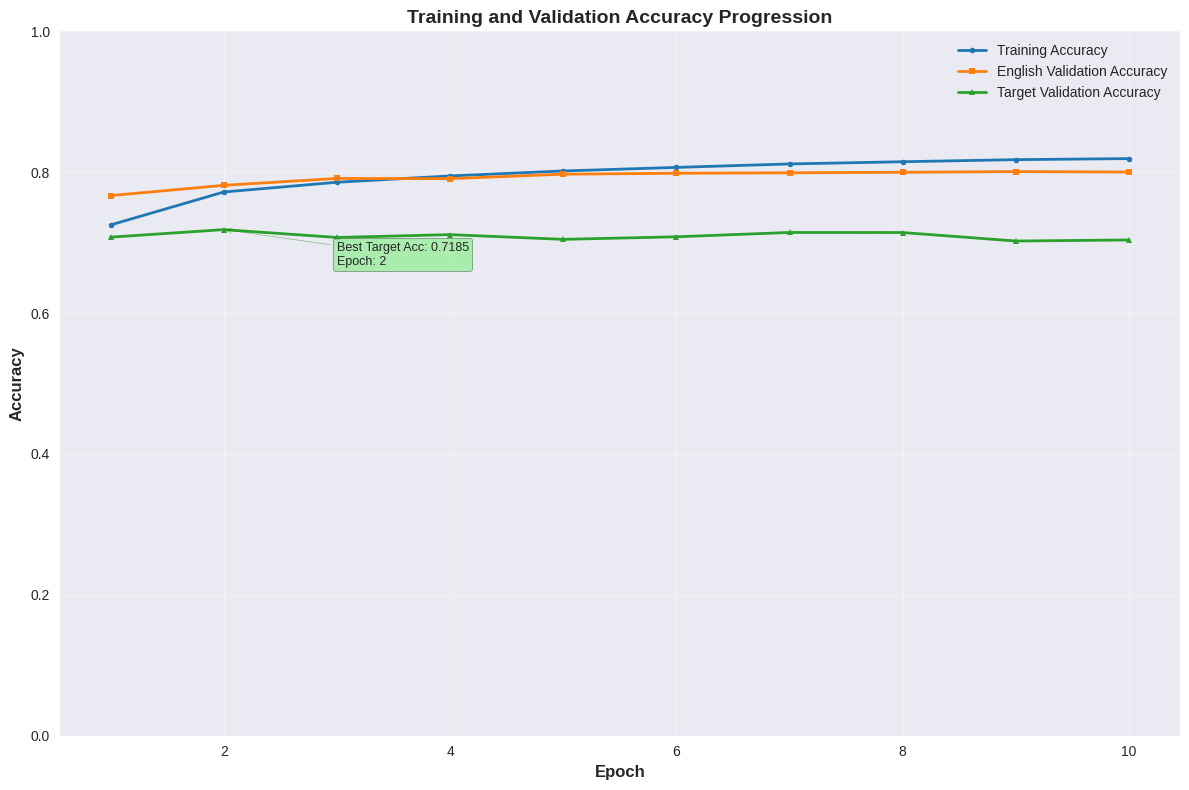

In [16]:
training_visualizer.plot_accuracies(history)

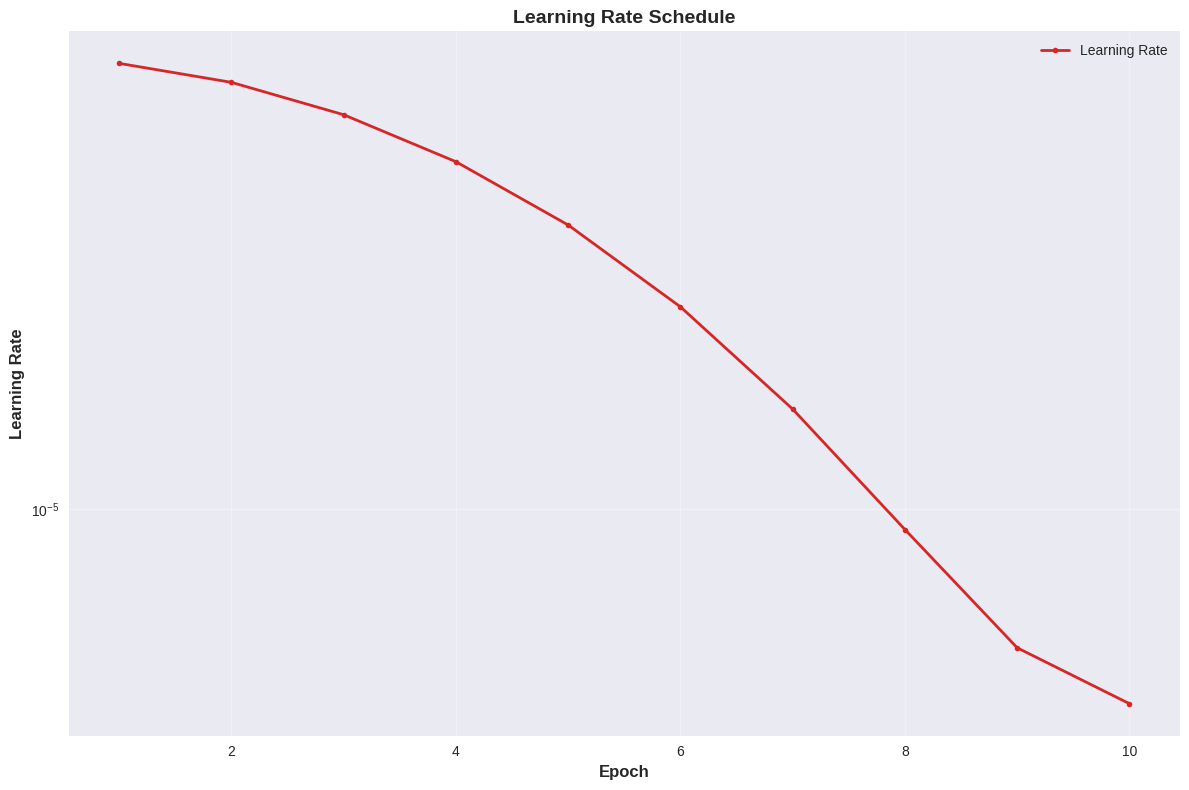

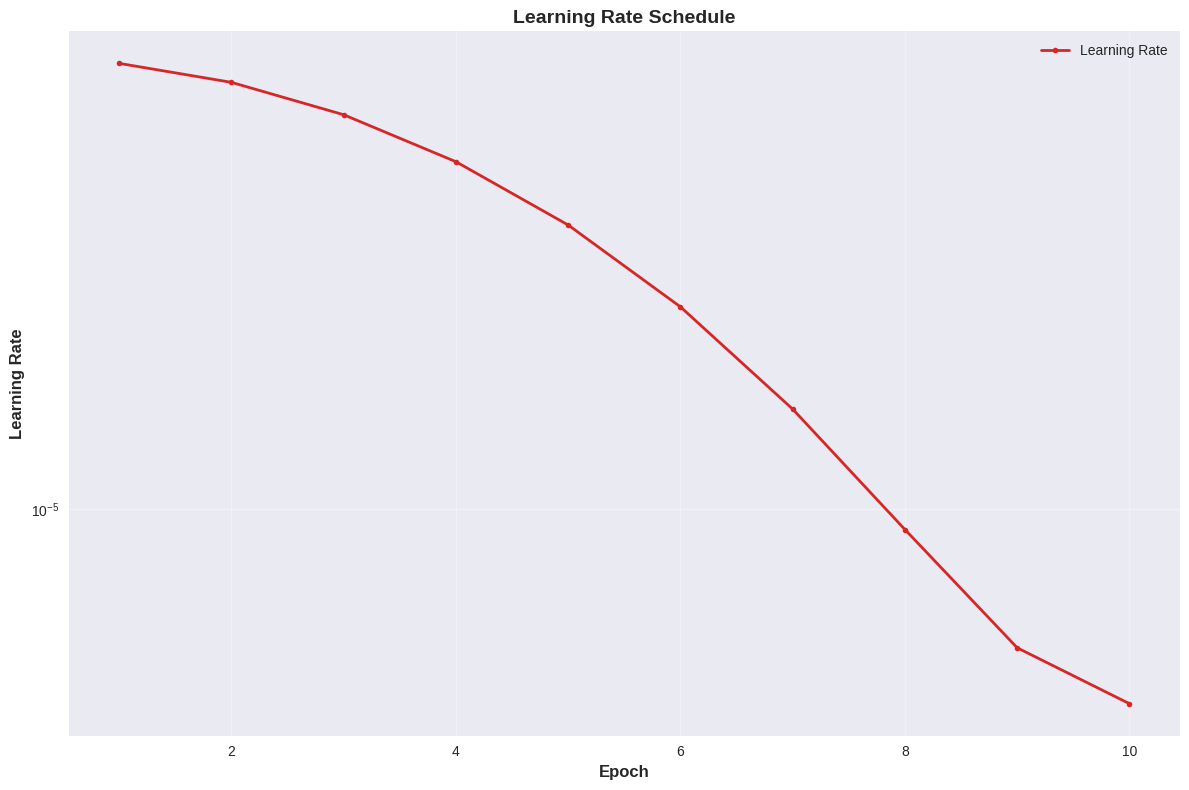

In [17]:
training_visualizer.plot_learning_rate(history)

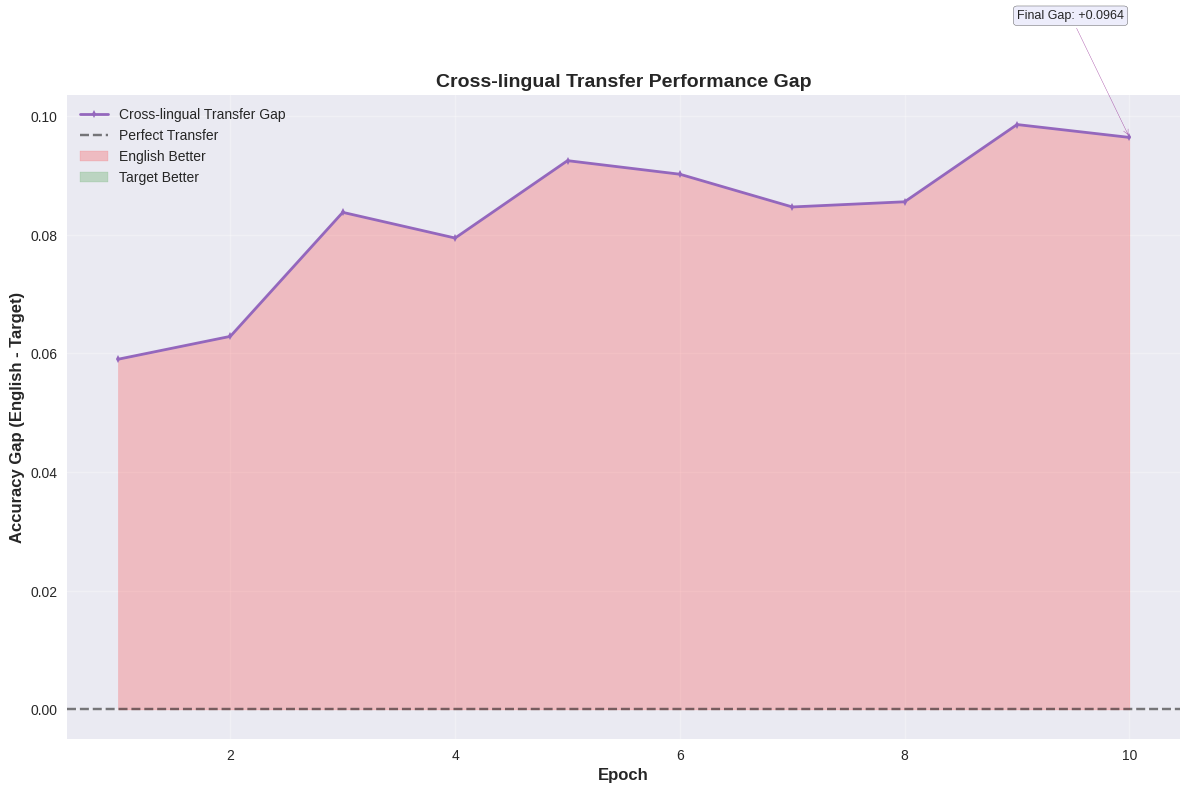

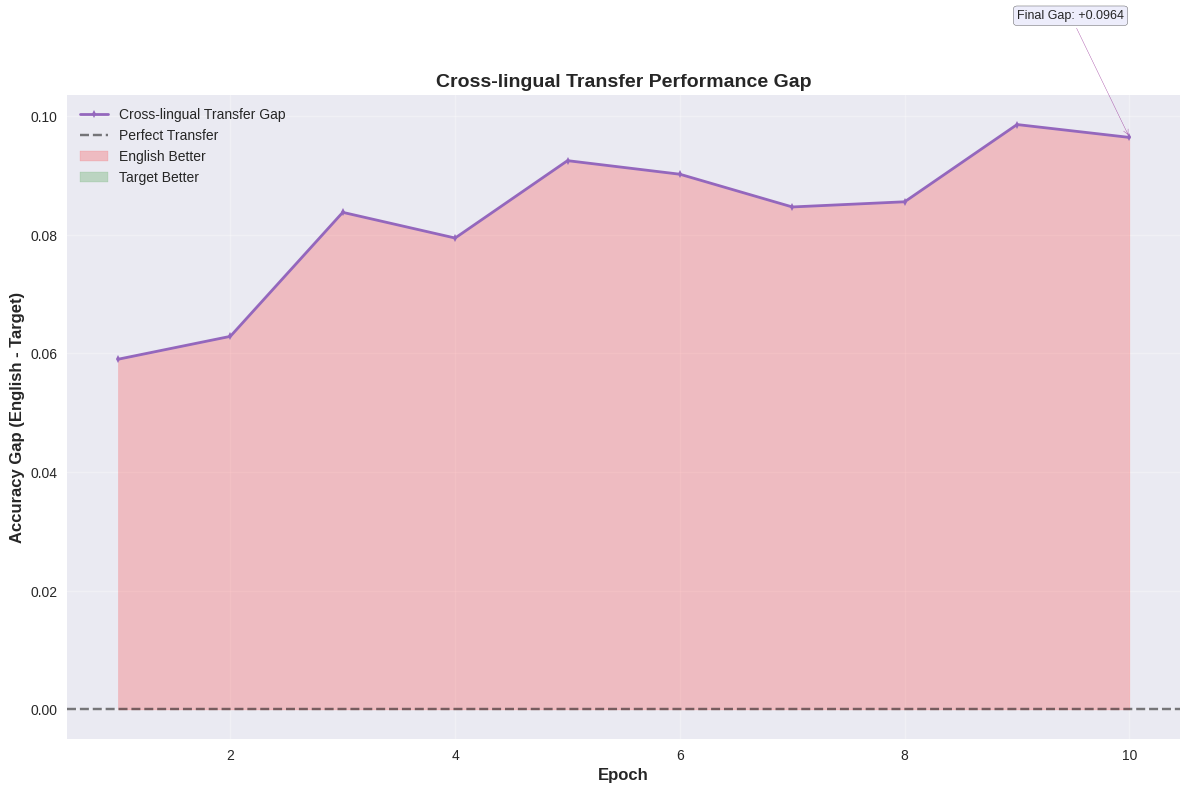

In [18]:
training_visualizer.plot_transfer_gap(history)

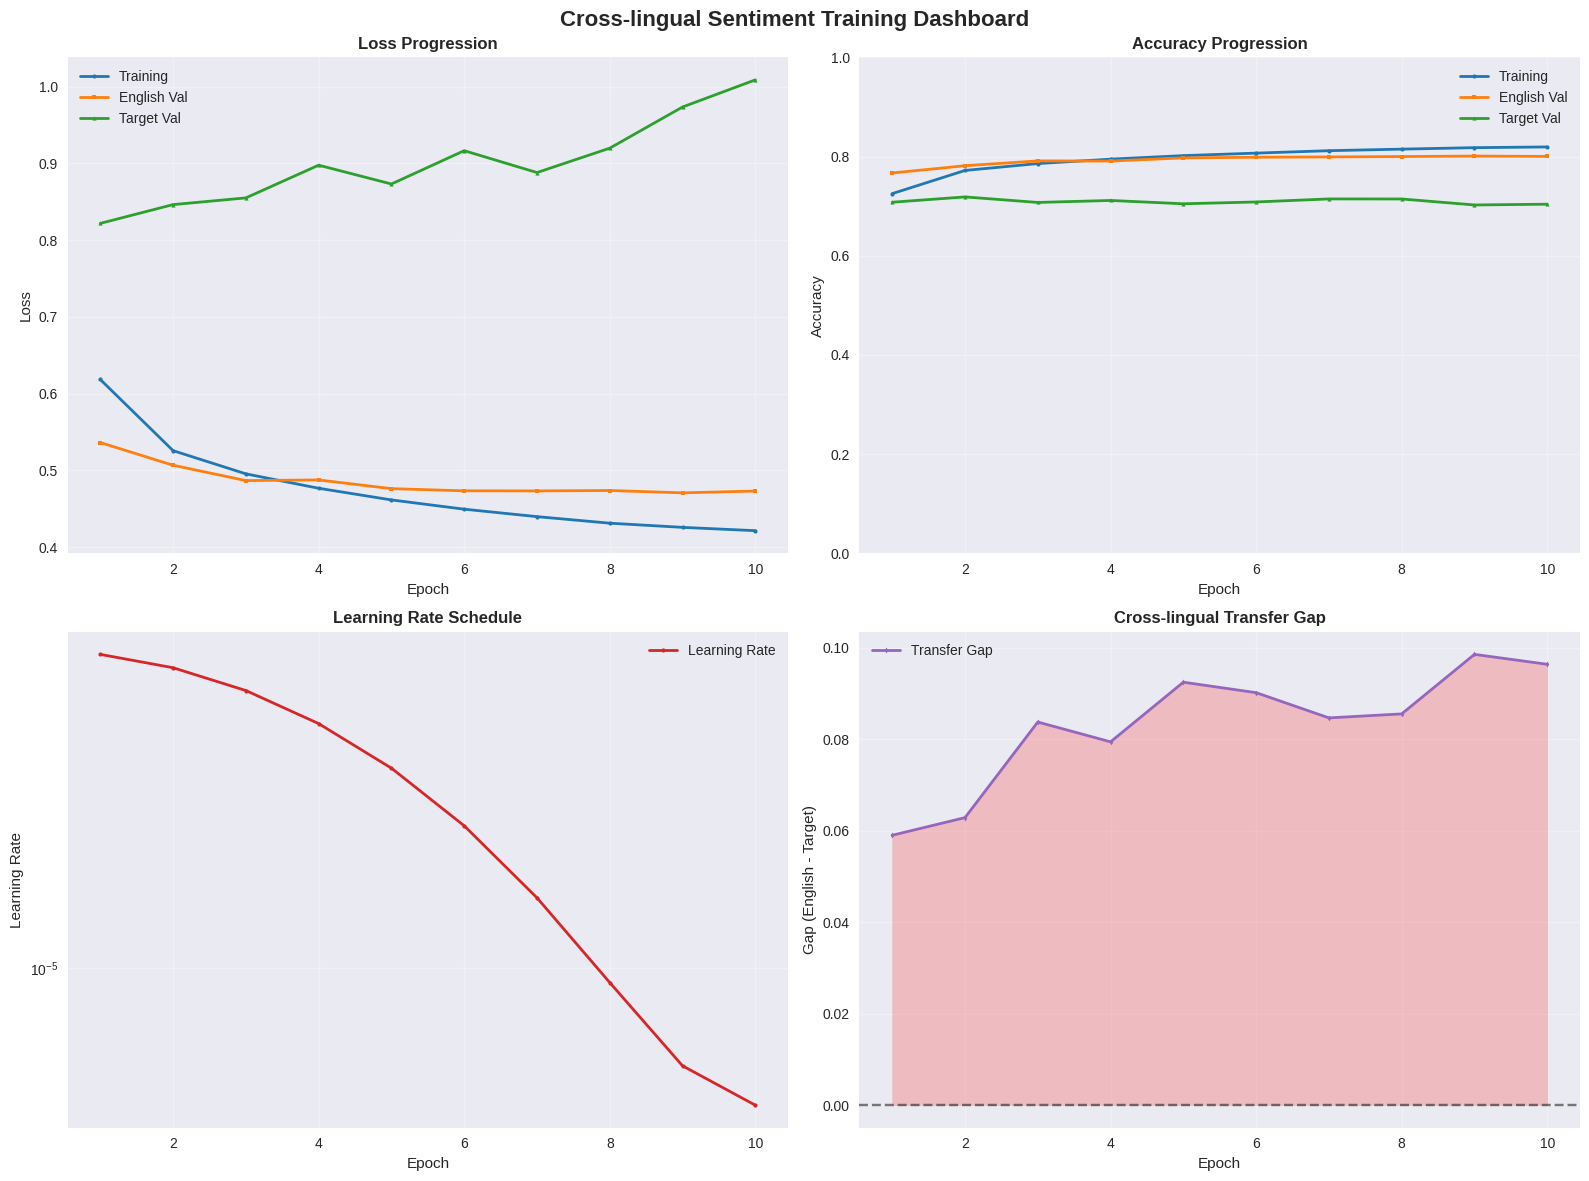

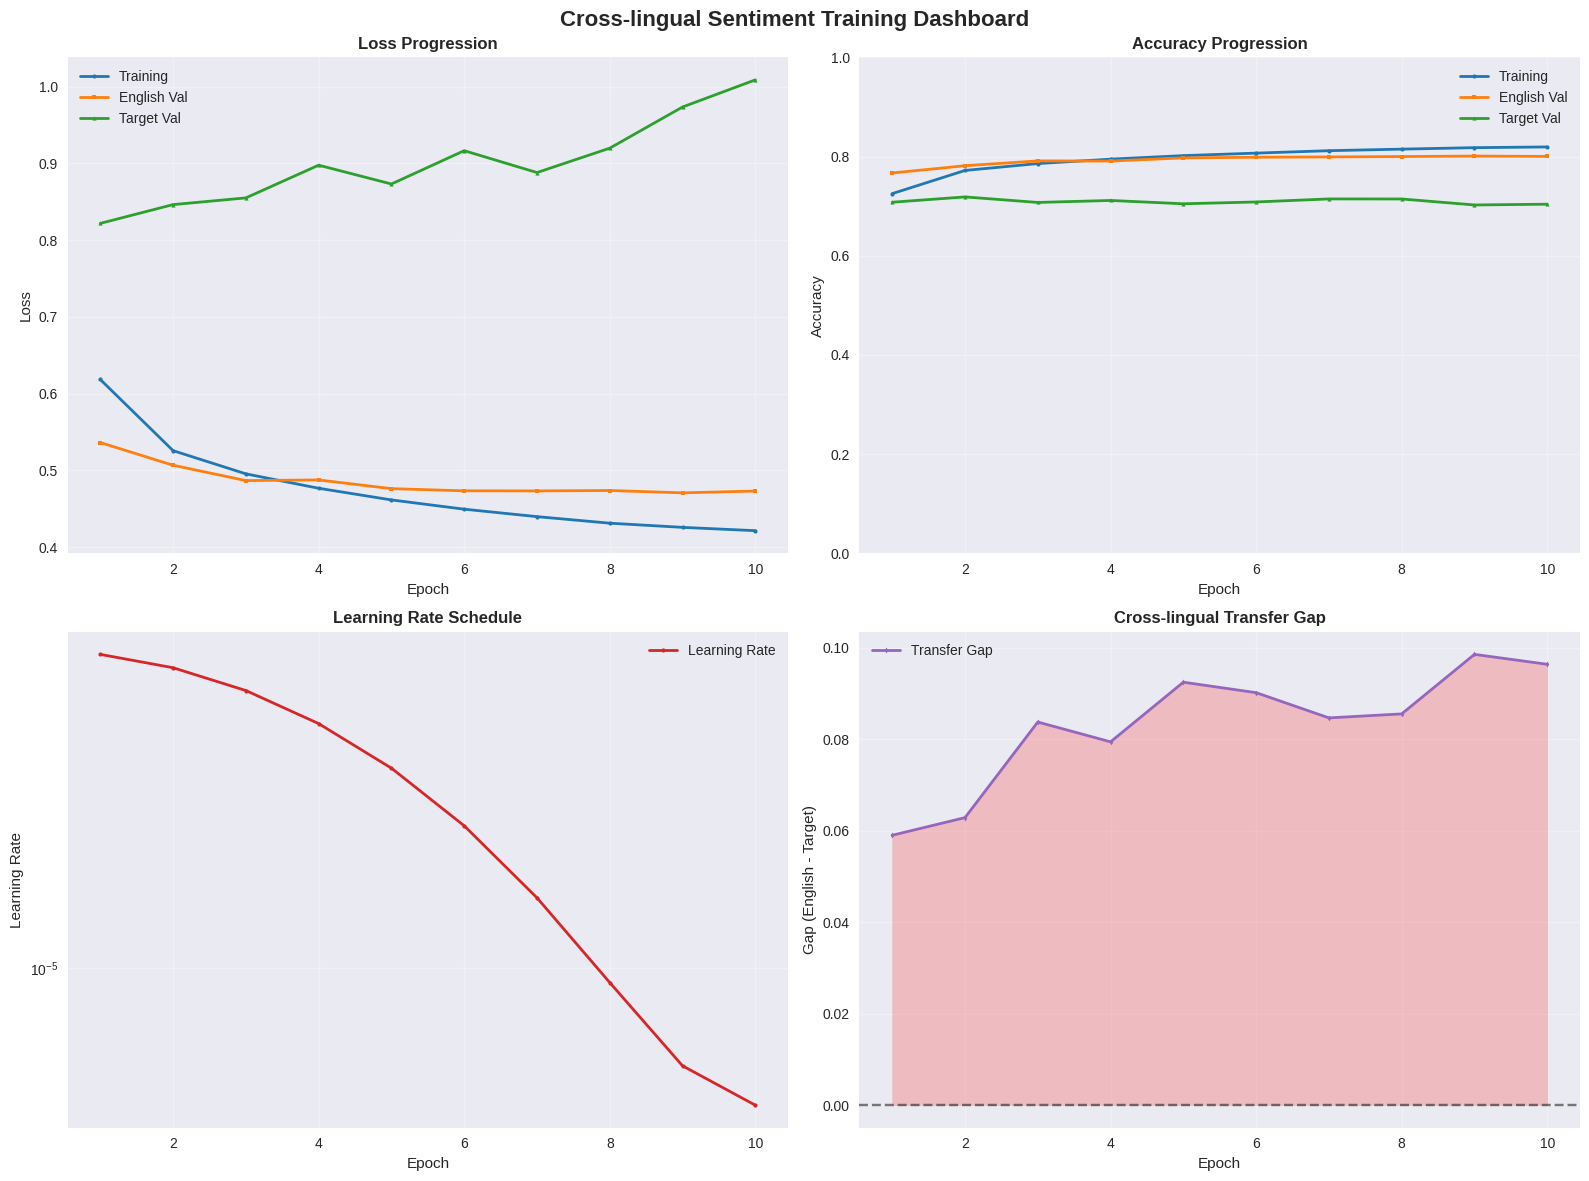

In [19]:
training_visualizer.plot_training_dashboard(history)

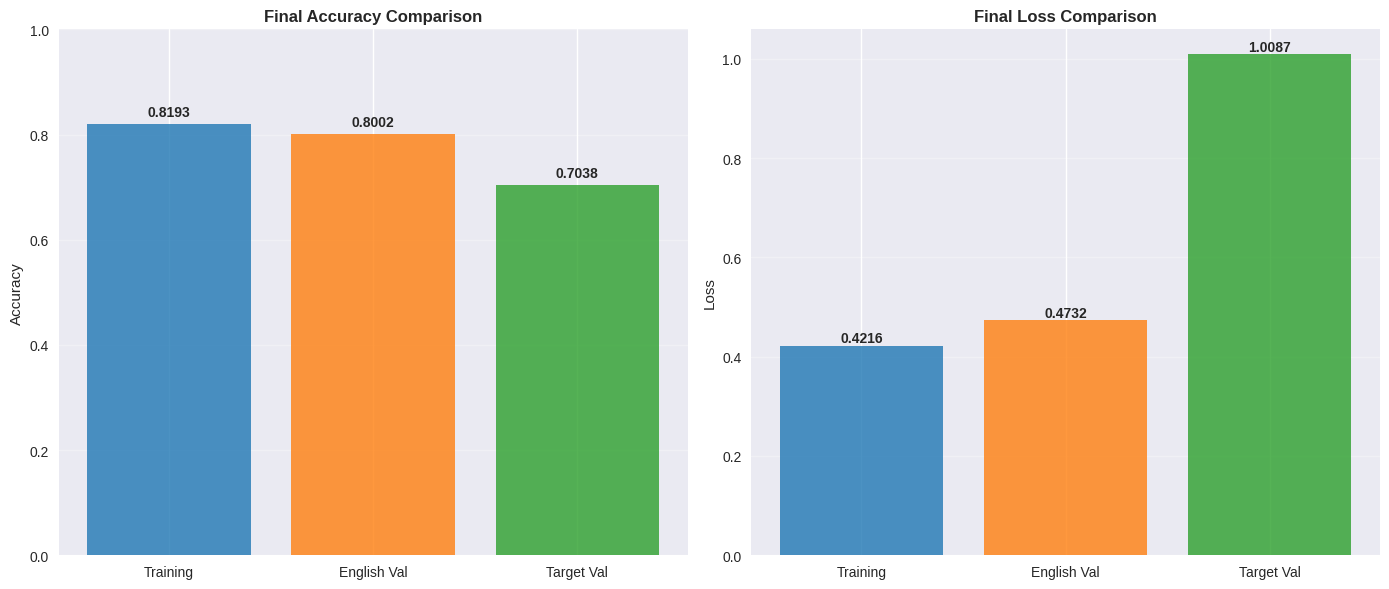

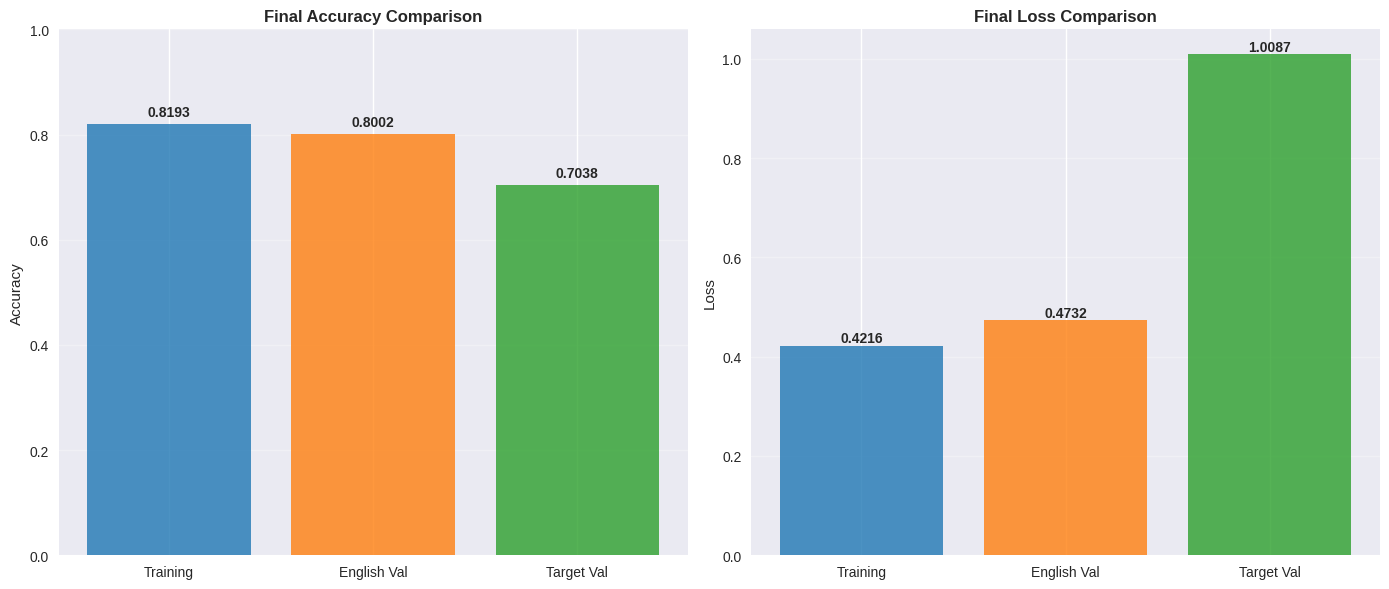

In [20]:
training_visualizer.plot_final_comparison(history)

Generating and saving all plots to plots/
Loss plot saved to plots/losses.png
Accuracy plot saved to plots/accuracies.png
Learning rate plot saved to plots/learning_rate.png
Transfer gap plot saved to plots/transfer_gap.png
Training dashboard saved to plots/dashboard.png
Final comparison saved to plots/final_comparison.png
Failed to generate ROC curve: 'NoneType' object has no attribute 'get_roc_data'
All plots saved successfully!


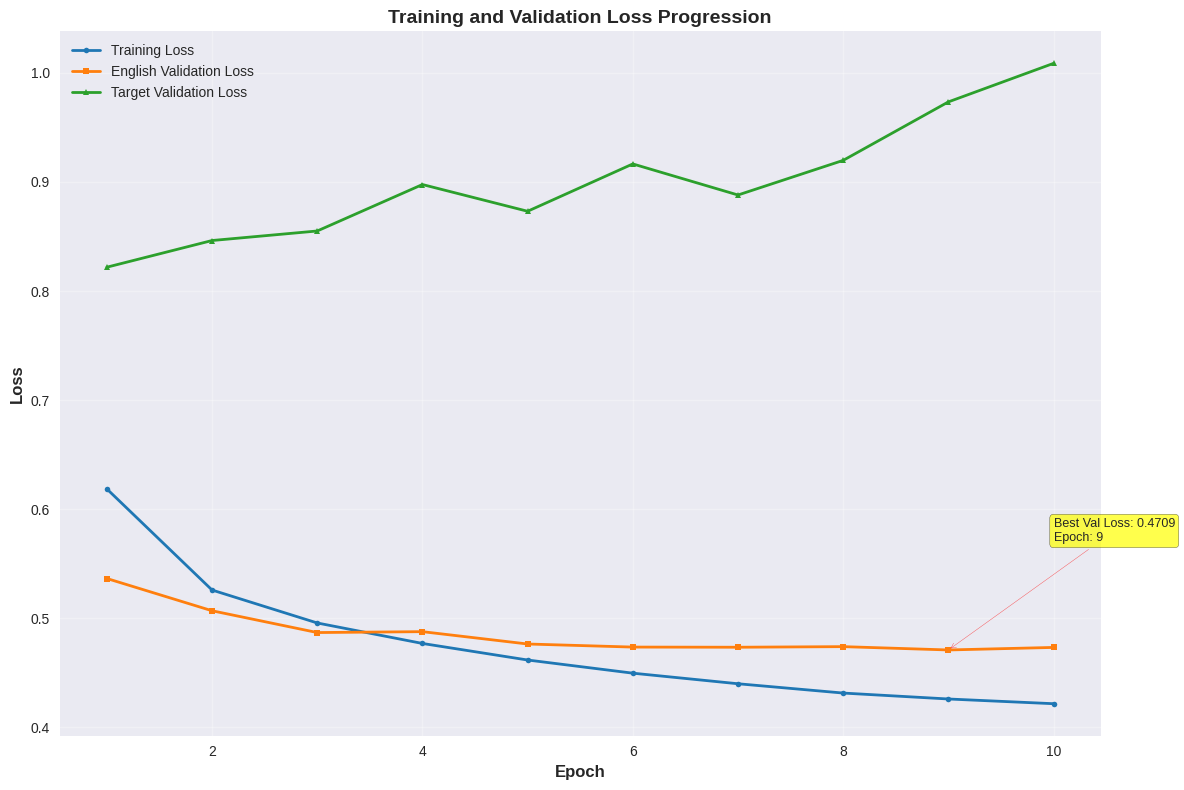

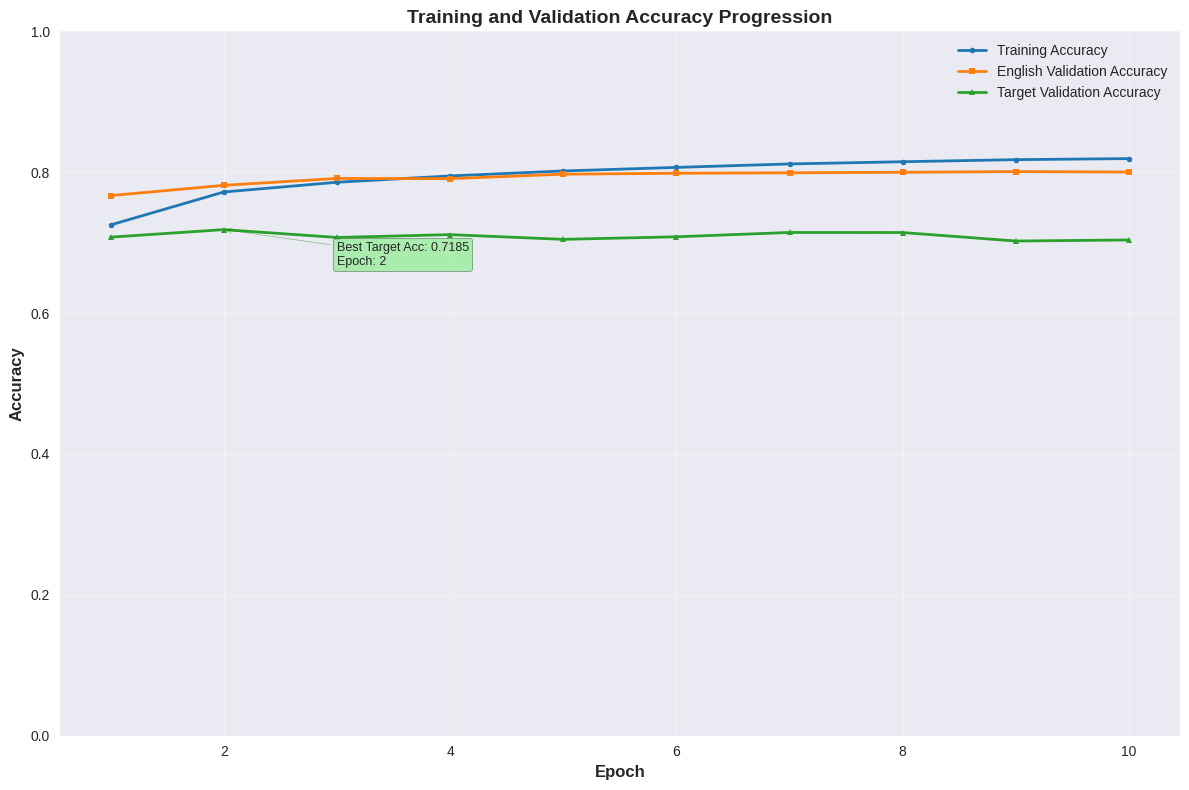

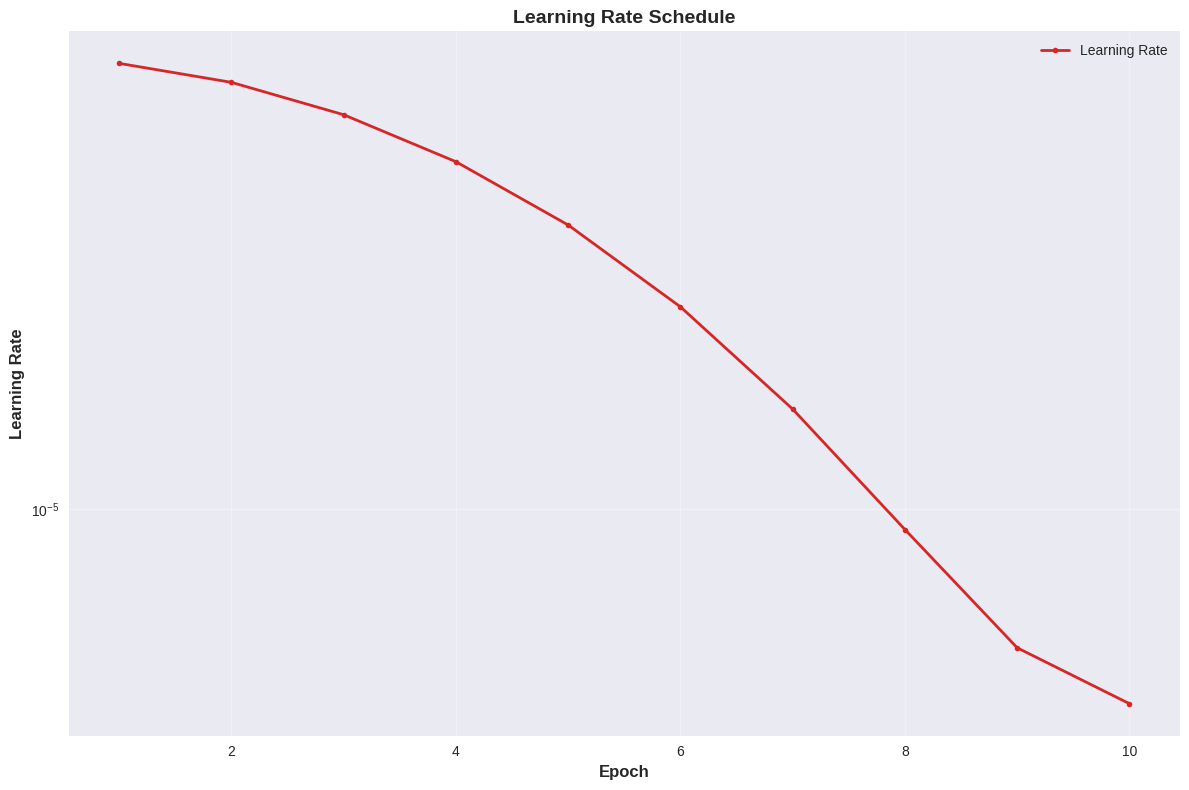

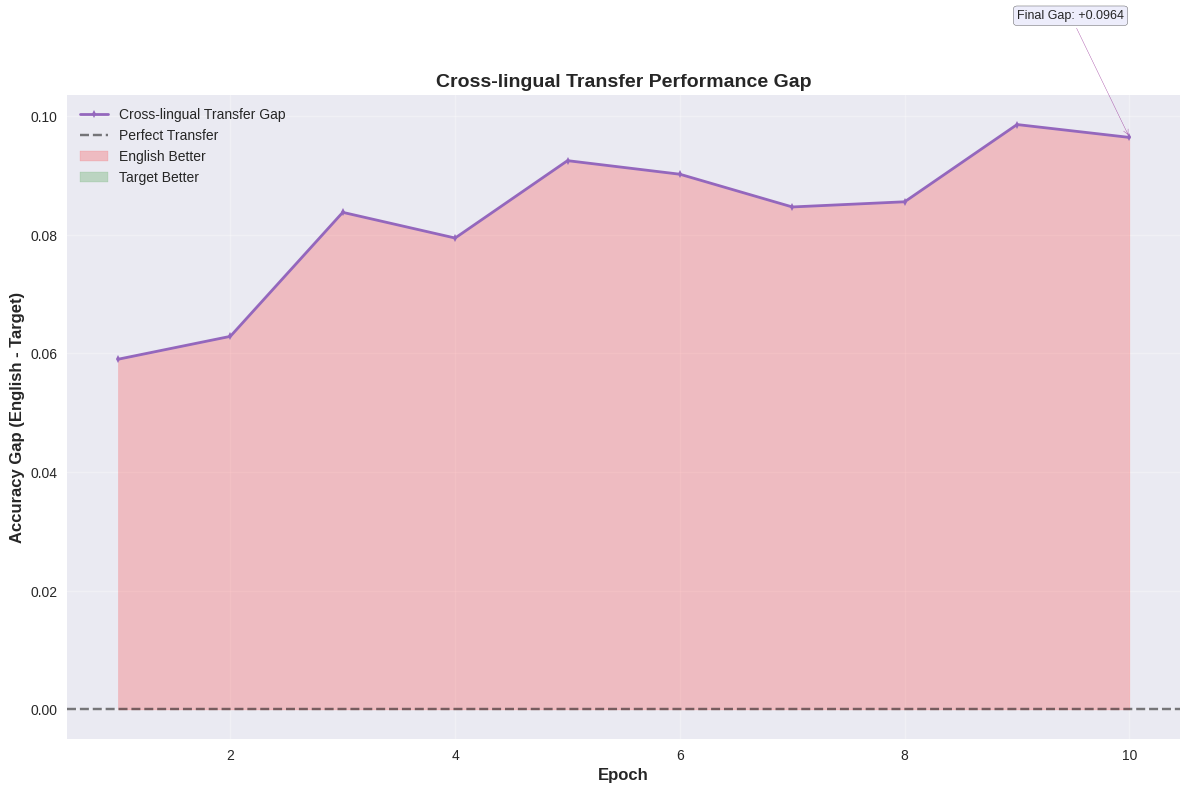

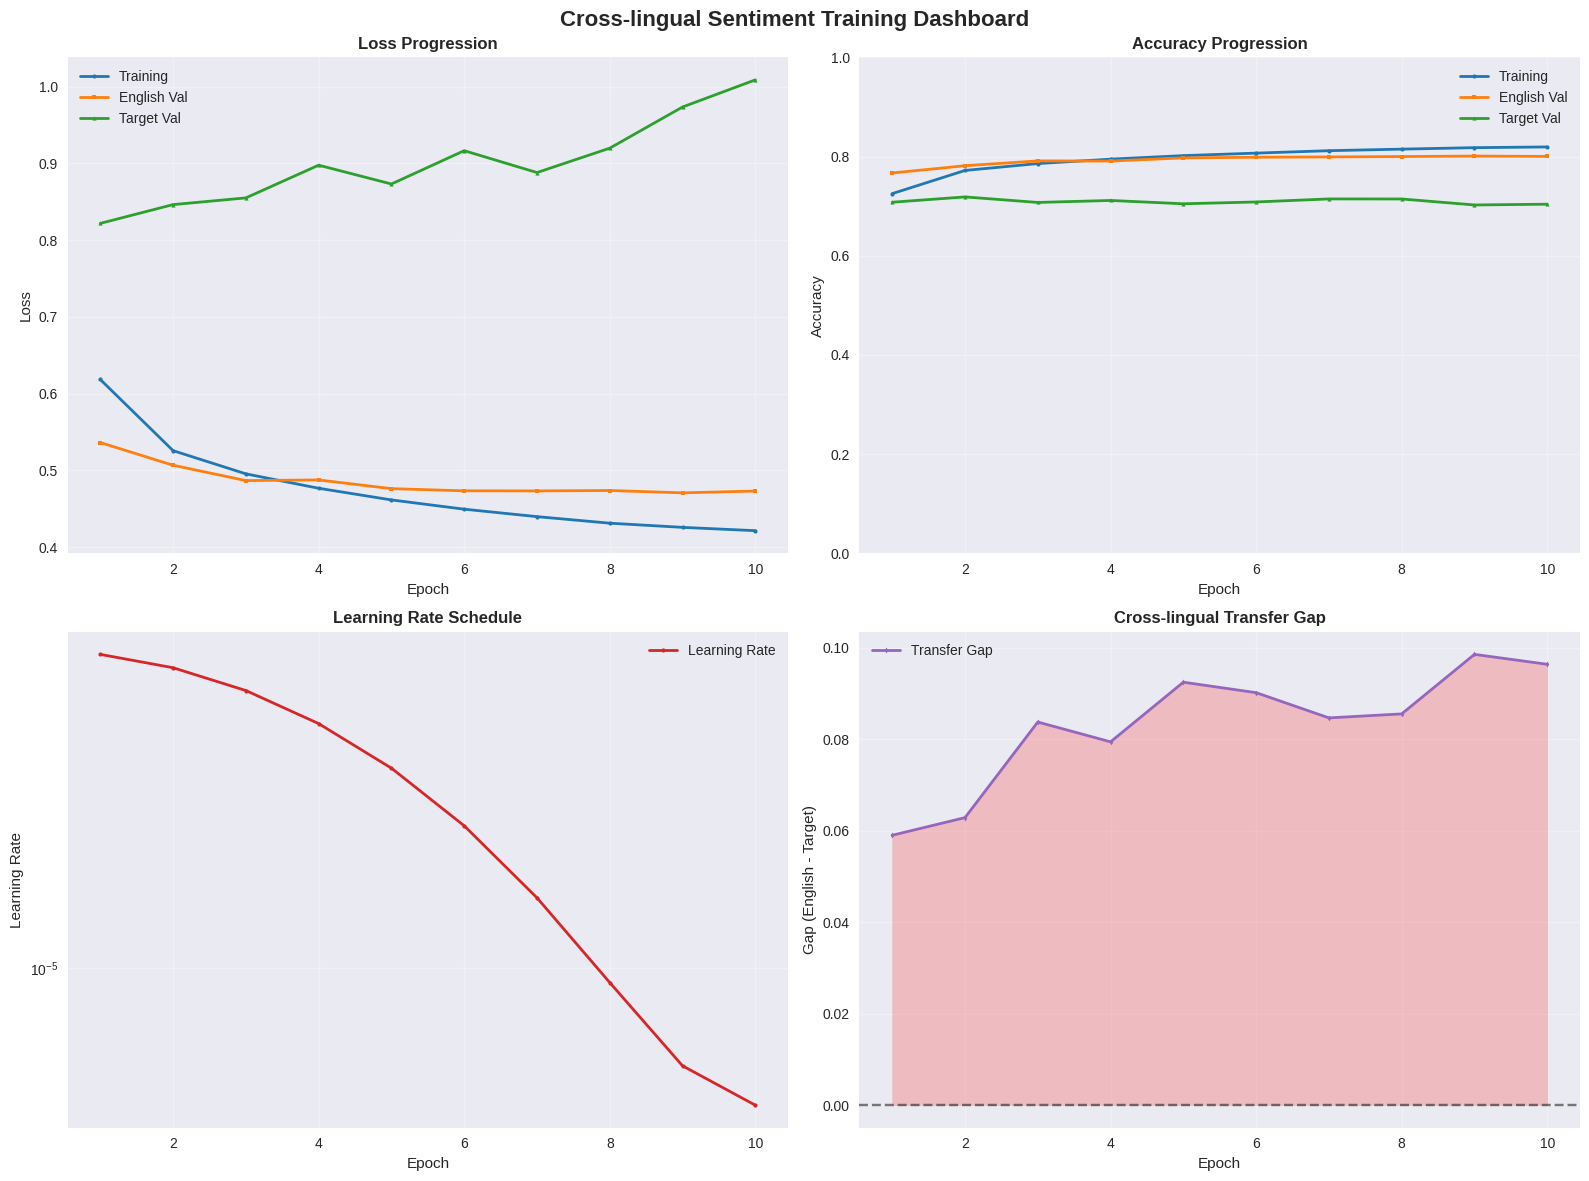

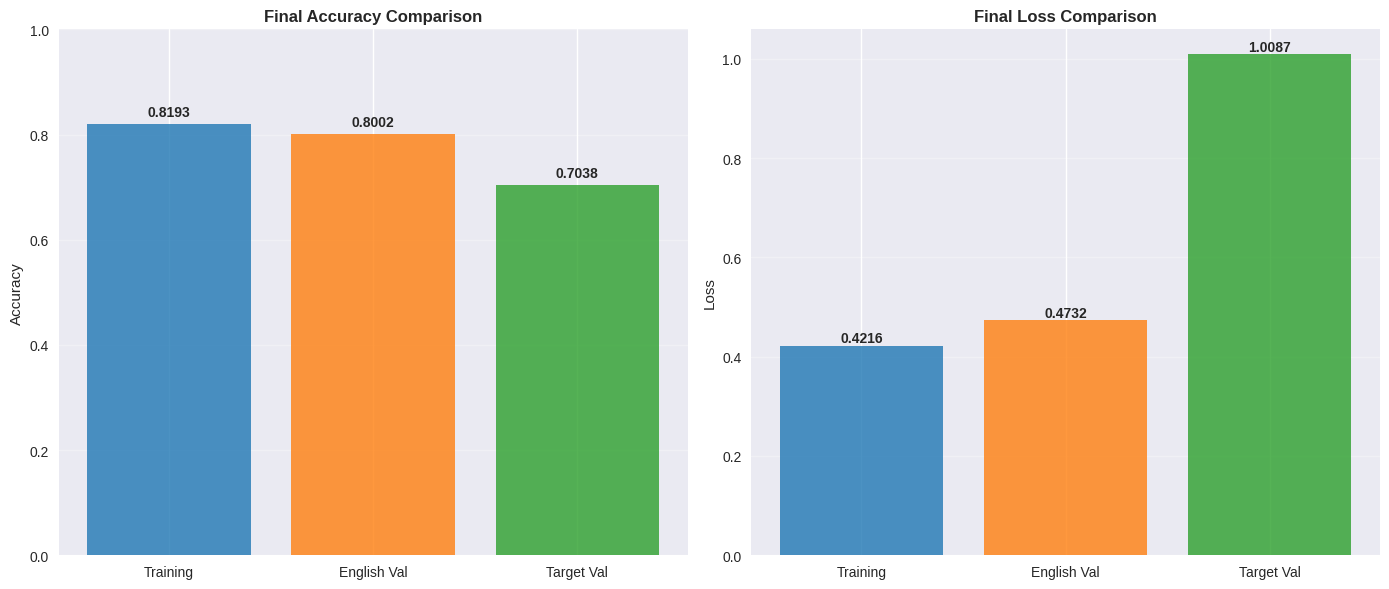

In [21]:
training_visualizer.save_all_plots(history)

Generating and saving all plots to plots/
Loss plot saved to plots/losses.png
Accuracy plot saved to plots/accuracies.png
Learning rate plot saved to plots/learning_rate.png
Transfer gap plot saved to plots/transfer_gap.png
Training dashboard saved to plots/dashboard.png
Final comparison saved to plots/final_comparison.png


Evaluating :   0%|          | 0/75 [00:00<?, ?it/s]

All plots saved successfully!


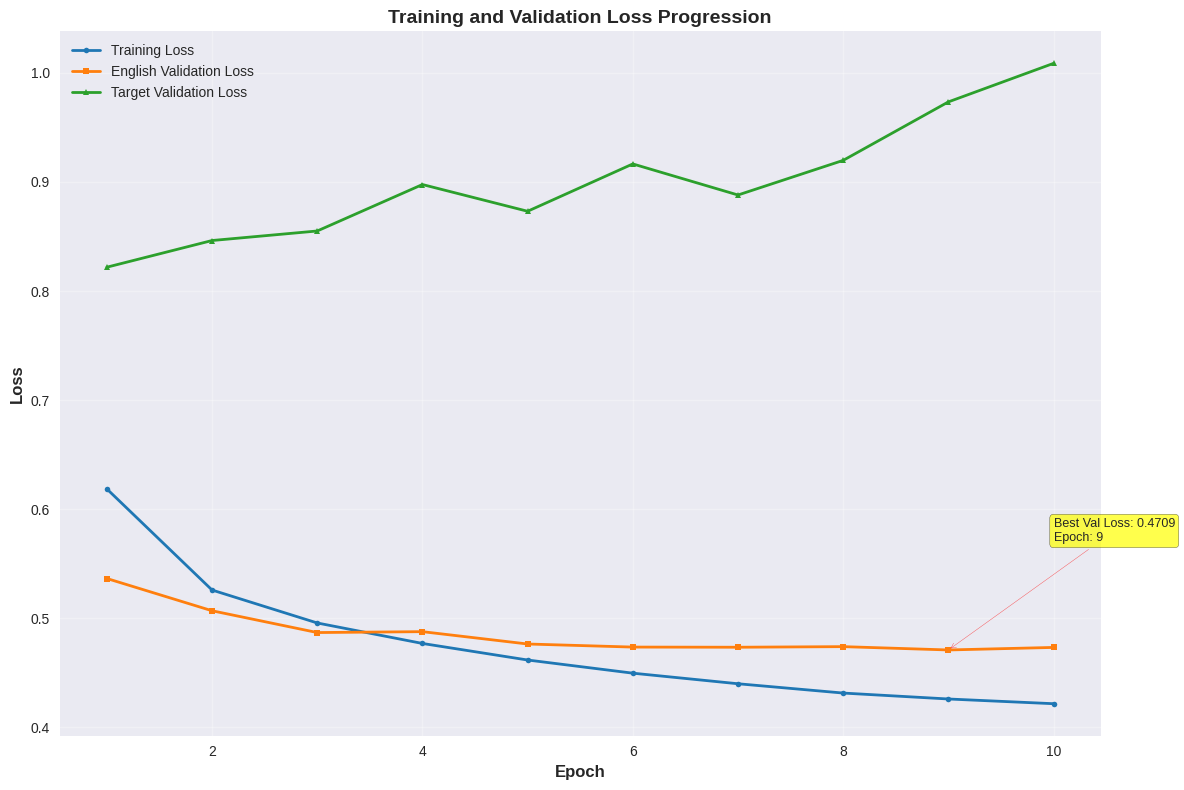

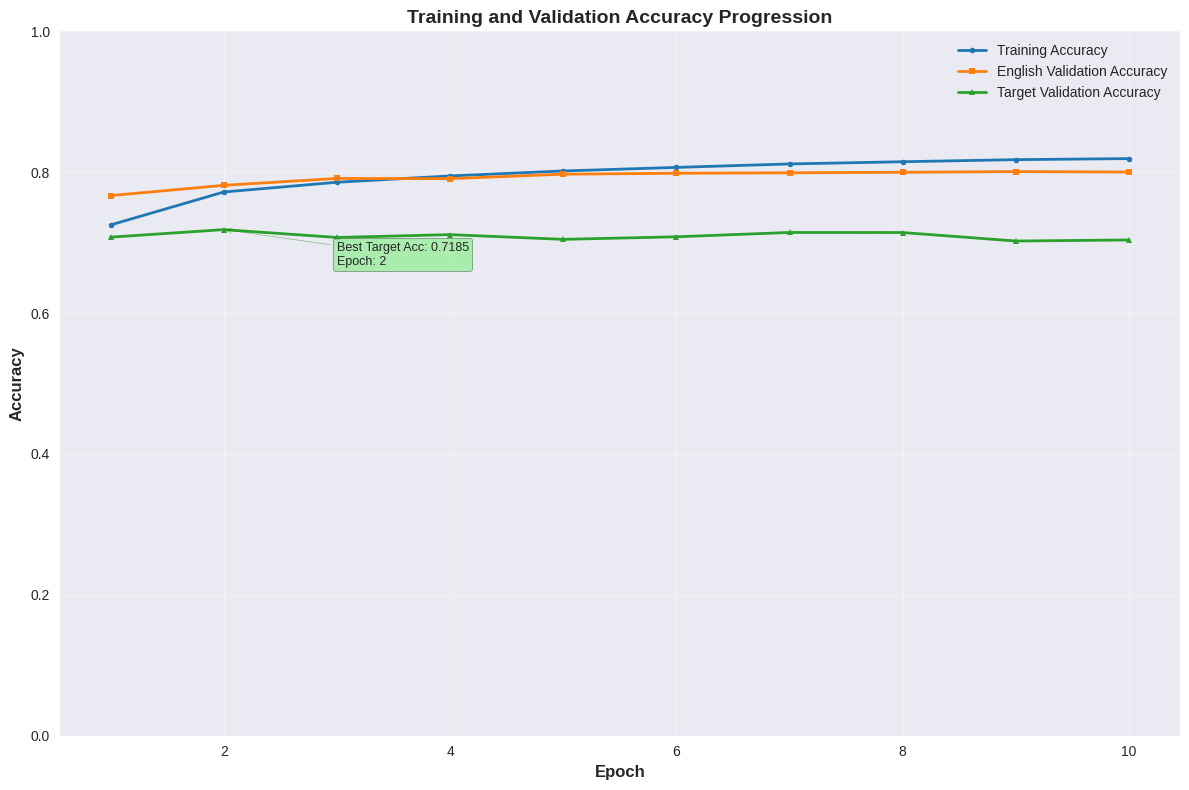

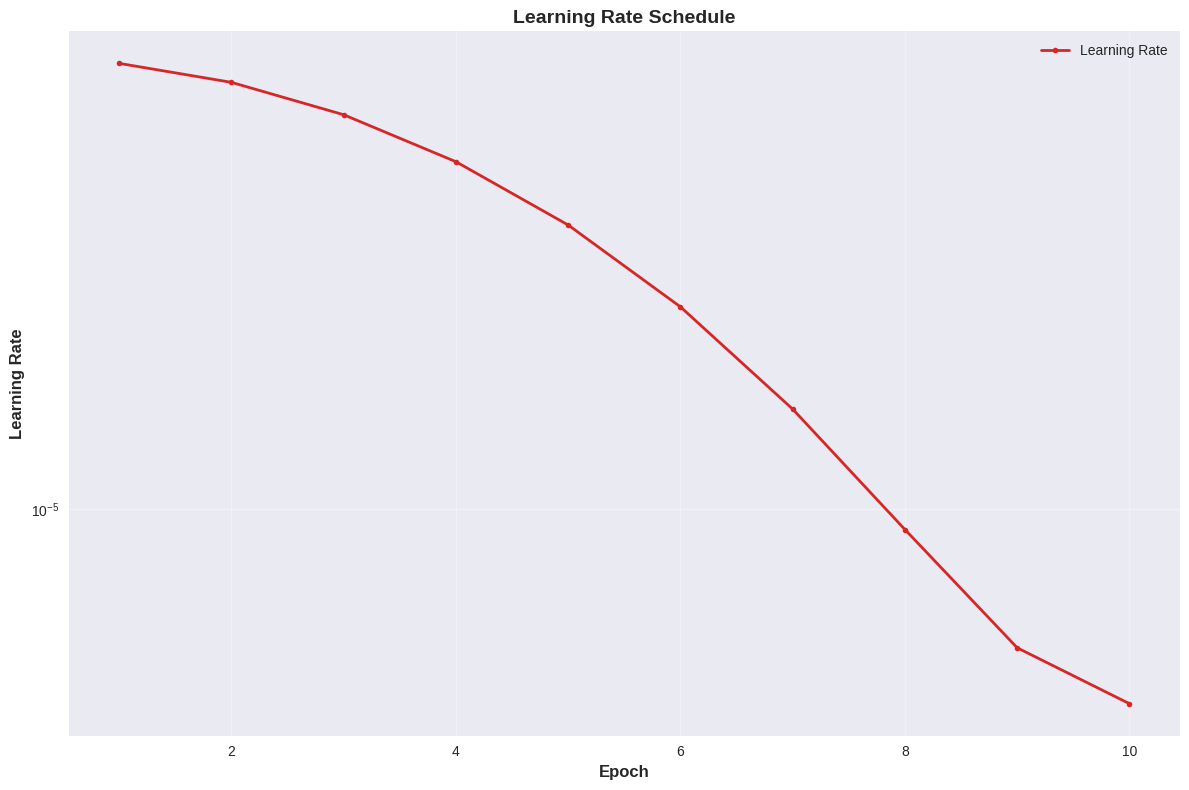

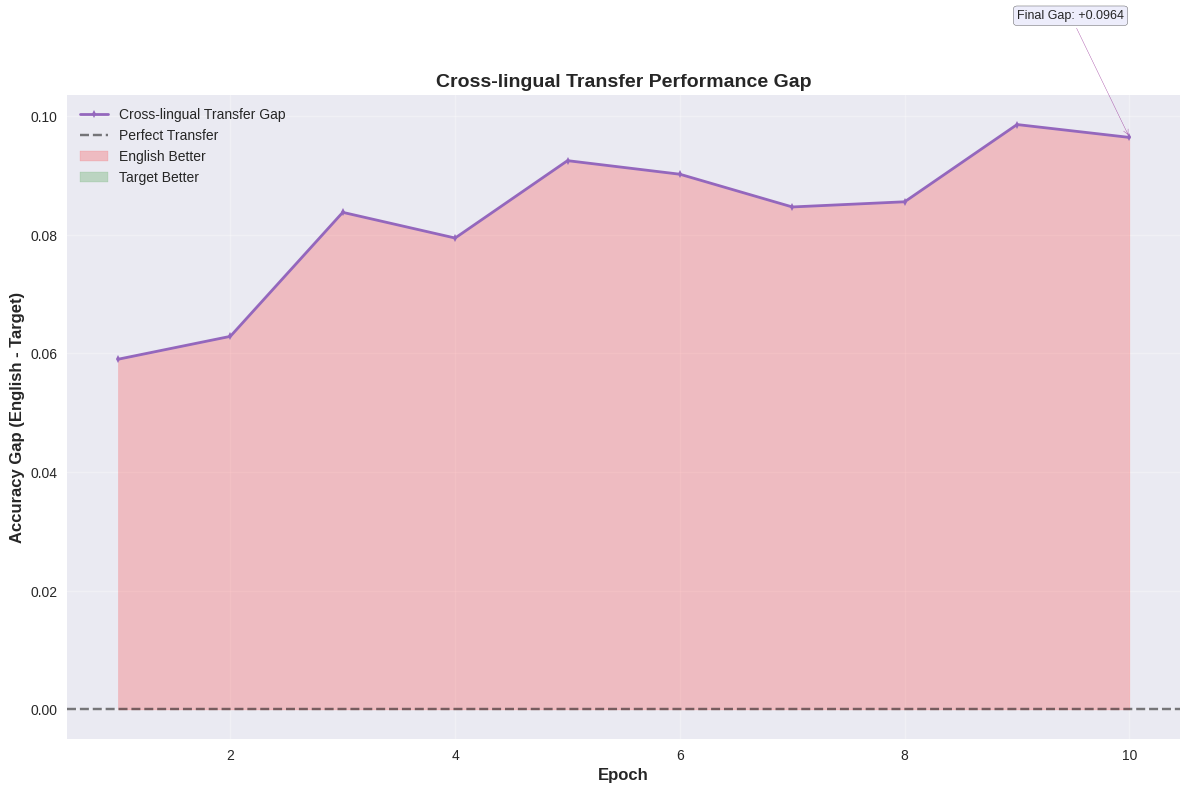

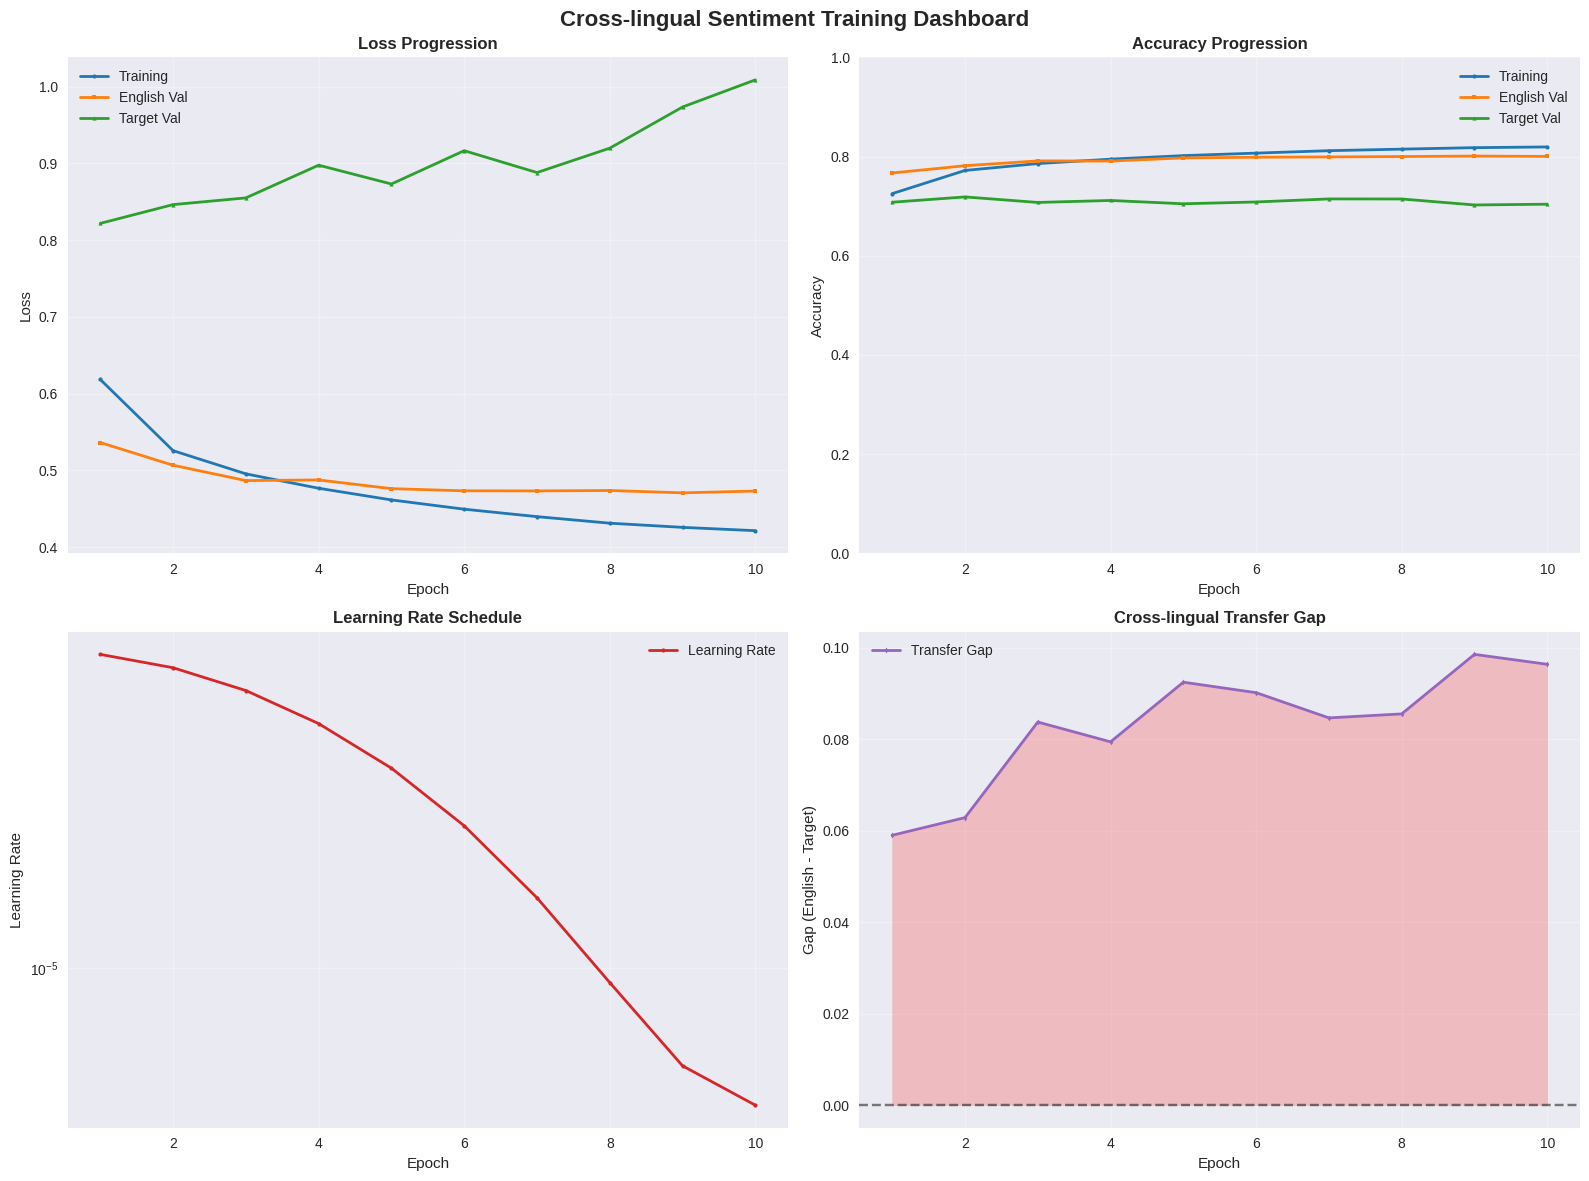

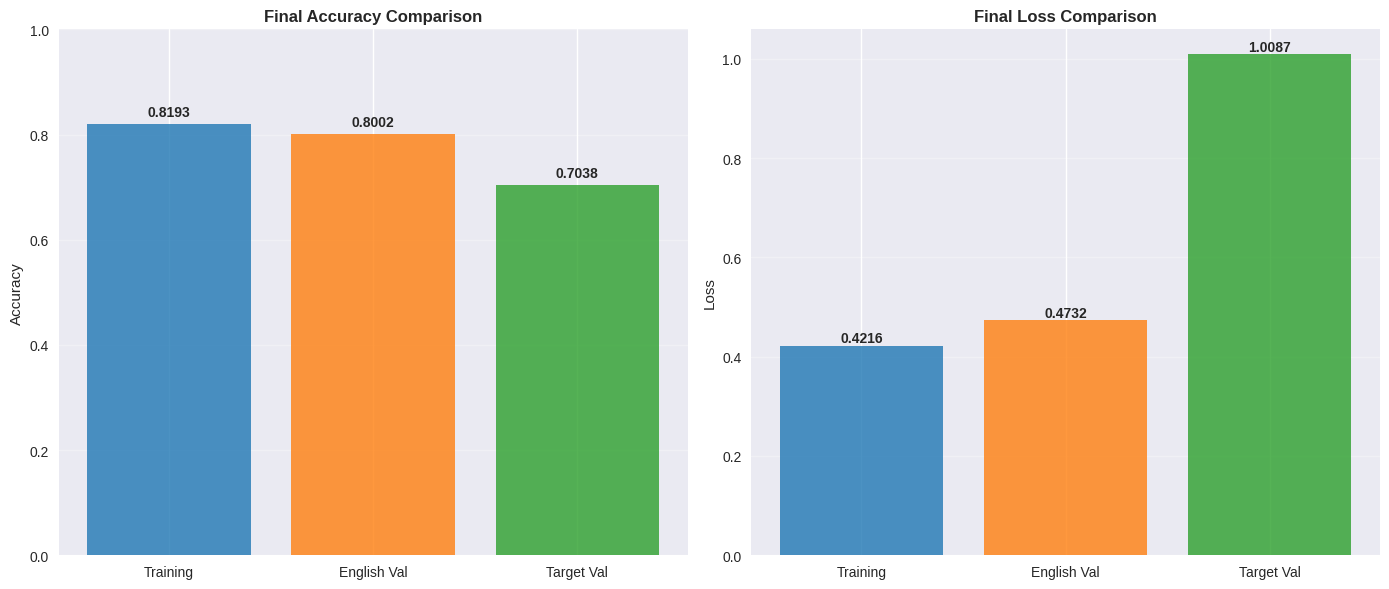

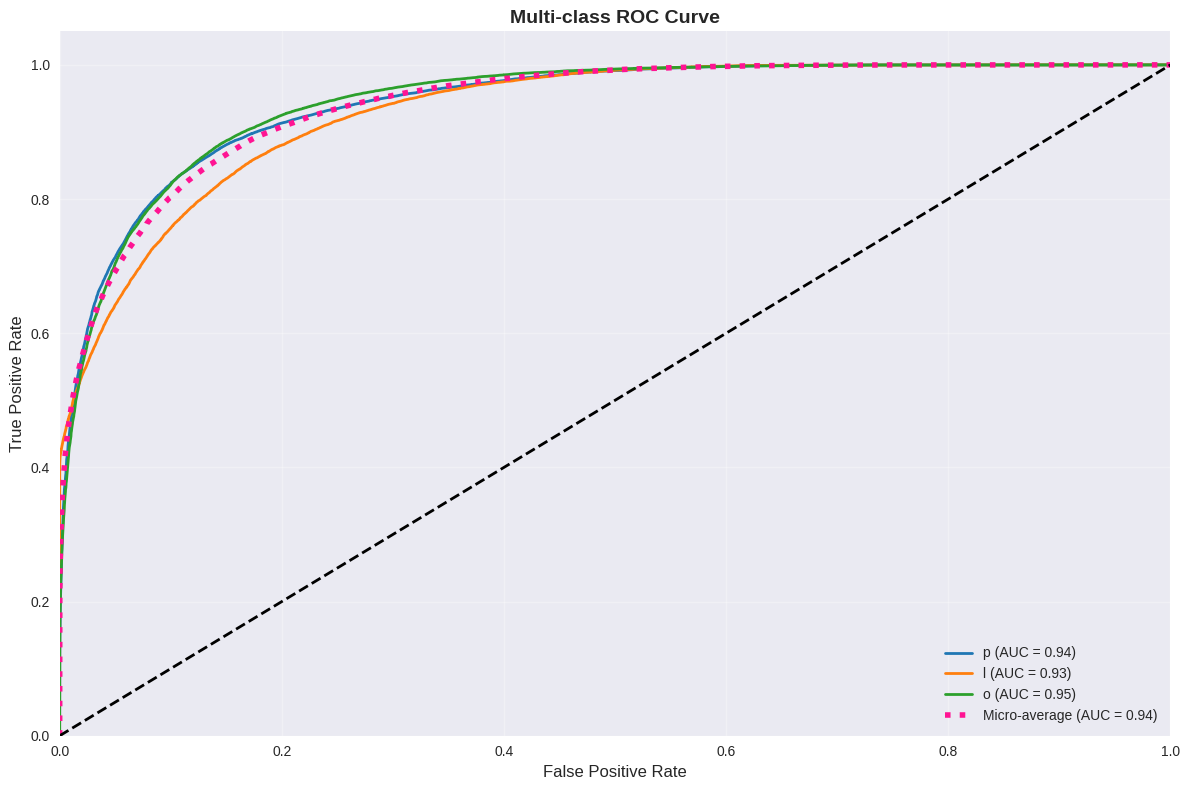

In [22]:
training_visualizer.save_all_plots(history, trainer)

In [23]:
import shutil

# This will create a zip file: /kaggle/working/working_dir.zip
shutil.make_archive('/kaggle/working/working_dir', 'zip', '/kaggle/working/')

'/kaggle/working/working_dir.zip'

In [24]:
# Zip the entire 'plots' folder
shutil.make_archive('/kaggle/working/plots_backup', 'zip', '/kaggle/working/plots')

'/kaggle/working/plots_backup.zip'